In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files  
from sklearn.model_selection import train_test_split

from keras.preprocessing import image     
from tqdm import tqdm
from PIL import Image
from random import shuffle


import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

import numpy as np




/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Problems
- Accuracy is good but no better than guess all one class. Think this could be solved by addressing class imbalance
- Accuracy is only good if we take the binary crossentropy and not the full label accuracy. Will need to speak to the lecturer about how to measure performance for this type of multilabel data. -> suggested splitting into sublabels and report average accuracy of models vs each of the different single label classification tasks. 

# TODO
- Need to balance the classes before passing them into the model. I.e. we need to take in more data to get a 50 50 split between having a disease and not, then run through the model. This should be possible as currently we're only processing 1% of the data. 10% is without any disease so that;s 20k. We then use another 20k with a disease. 
- Also need to add the gender and age into the x train so the model can use this information as well as the image. 
- May want to pass the data into a high res image generator or use the high res images, which would require using the GPU servers
- To allow a more complex model to learn quickly on the gpu servers, may want to try using transfer learning from an existing model

# Done
- Need to change all the unknowns into positives as evidenced by the success of u-ones model on this paper: https://arxiv.org/pdf/1901.07031.pdf

In [2]:
trainDf = pd.read_csv('CheXpert-v1.0-small/train.csv')

# Remove anomalous dataline
trainDf = trainDf[trainDf.Sex != 'Unknown']
# Drop this column as it has many more classifications than lit suggests and shouldn't matter greatly for a CNN
# TODO try with and without this column
trainDf = trainDf.drop('AP/PA', 1)

def pathToID(path):
    pathList = path.split('/')
    return pathList[2][7:]

def pathToStudy(path):
    pathList = path.split('/')
    return pathList[3][5:]

# Convert all labels to a series of one-hot encoded labels. 
trainDf = trainDf.fillna(-1)
# N.B. this is replacing unknowns with true as per u-ones model here: https://arxiv.org/pdf/1901.07031.pdf
# Note this also has the effect of changing age 0 patients to age 1 but this is not necessarily a problem given that the next nearest aged patient is 18
trainDf = trainDf.replace(0,1) 
trainDf = trainDf.replace(-1,0)

# Onehot encode the sex and the xray orientation
trainDf = trainDf.replace('Male',1)
trainDf = trainDf.replace('Female',0)
trainDf = trainDf.replace('Frontal',1)
trainDf = trainDf.replace('Lateral',0)

trainDf =trainDf.rename(index=str, columns={"Sex": "Male?",'Frontal/Lateral' :'Frontal1/Lateral0'})


#trainDf.insert(0,'Path', trainDf['Path'])
trainDf['Study'] = trainDf.Path.apply(pathToStudy)
trainDf['Patient ID'] = trainDf.Path.apply(pathToID)

# Rearrange Columns
cols = ['Patient ID', 'Study', 'Path', 'Age', 'Male?', 'Frontal1/Lateral0', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
trainDf = trainDf[cols]



# Preliminary Analysis

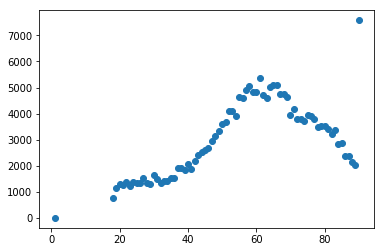

In [3]:
# Shows age distribution of the data set. There are 3 0-olds and 7579 90 year olds. 
# Implies that over nineties were grouped together
ages = trainDf['Age'].value_counts()
plt.scatter(ages.keys(),ages.values)

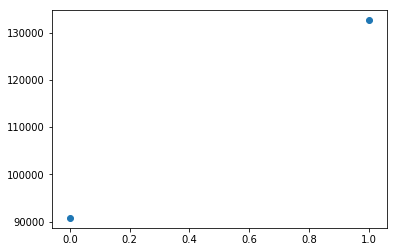

In [4]:
gender = trainDf['Male?'].value_counts()
plt.scatter(gender.keys(),gender.values)

0.0    201033
1.0     22380
Name: No Finding, dtype: int64


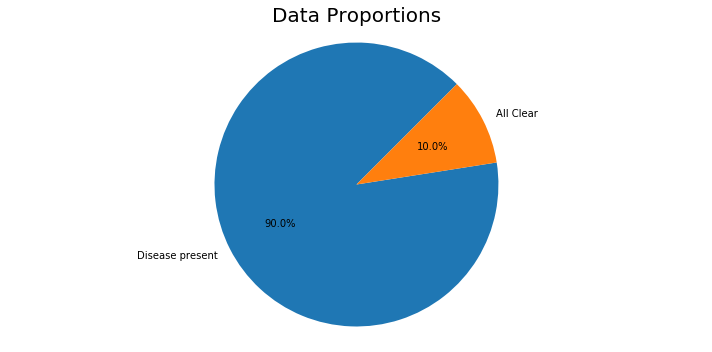

In [5]:
# How many people have no disease?
no_finding = trainDf['No Finding'].value_counts()
print(no_finding)

# Plot pie chart to show how much of the data is labelled with each character
values = no_finding.values
labels = ['Disease present','All Clear']

# Plot
plt.figure(figsize=(10, 5))
plt.title('Data Proportions', size=20)
plt.pie(values, labels=labels, # explode=explode,
        autopct='%1.1f%%', shadow=False, startangle=45)
 
plt.axis('equal')
plt.tight_layout()
plt.show()



In [6]:
trainDf

,Patient ID,Study,Path,Age,Male?,Frontal1/Lateral0,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,00001,1,CheXpert-v1.0-small/train/patient00001/study1/...,68,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,00002,2,CheXpert-v1.0-small/train/patient00002/study2/...,87,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,00003,1,CheXpert-v1.0-small/train/patient00003/study1/...,41,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,1,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,1,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,00005,2,CheXpert-v1.0-small/train/patient00005/study2/...,33,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    return files


def path_to_tensor(img_path,inputSize):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, color_mode = "grayscale", target_size=inputSize)
    # convert PIL.Image.Image type to 3D tensor with shape (x, x, 1)
    x = image.img_to_array(img)
    data = np.asarray( img, dtype="int32" )
    # convert 2D tensor to 3D tensor with shape (1, X, x) and return 3D tensor
    return data.reshape(1,inputSize[0],inputSize[1])

def paths_to_tensor(img_paths, inputSize):
    list_of_tensors = [path_to_tensor(img_path, inputSize) for img_path in img_paths]
    return np.array(list_of_tensors)


def path_to_tensor_channel_last_3colour(img_path,inputSize):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, color_mode = "grayscale", target_size=inputSize)
    # convert PIL.Image.Image type to 3D tensor with shape (x, x, 1)
    x = image.img_to_array(img)
    data = np.asarray( img, dtype="int32" )
    # convert 2D tensor to 3D tensor with shape (1, X, x) and return 3D tensor
    #data = data.reshape(inputSize[0],inputSize[1],1)
    return np.stack((data,)*3, axis=-1)


def paths_to_tensor_channel_last_3colour(img_paths, inputSize):
    list_of_tensors = [path_to_tensor_channel_last_3colour(img_path, inputSize) for img_path in img_paths]
    return np.array(list_of_tensors)

In [8]:
inputSize = (224,224)

sample_size = 1000
targetColumn = [6]
colName = trainDf.columns.tolist()[targetColumn[0]]
print(f"This model will be targetting {colName} column")


# Create balanced dataset with 50% pos examples and 50% neg examples, only take frontal scans for now
pos = trainDf[(trainDf[colName] == 1) & (trainDf['Frontal1/Lateral0'] == 1 )]
neg = trainDf[(trainDf[colName] == 0) & (trainDf['Frontal1/Lateral0'] == 1 )]
del trainDf

This model will be targetting No Finding column


In [9]:


posSample = pos.sample(int(sample_size/2))
negSample = neg.sample(int(sample_size/2))
sample = pd.concat([posSample,negSample])


x_train_paths, x_val_paths, y_train, y_val = train_test_split(sample.Path, sample[colName], stratify=sample[colName], random_state =2)


#x_train = paths_to_tensor(x_train_paths,inputSize)#.astype('float32')/255
x_train3Channel = paths_to_tensor_channel_last_3colour(x_train_paths,inputSize)#.astype('float32')/255

#y_train = trainDf.iloc[:training_no,targetColumn] # to do all labels: trainDf.iloc[:training_no,8:]
#x_val = paths_to_tensor(x_val_paths,inputSize)#.astype('float32')/255
x_val3Channel = paths_to_tensor_channel_last_3colour(x_val_paths,inputSize)#.astype('float32')/255

#y_val = trainDf.iloc[training_no:training_no+val_no,targetColumn]




In [29]:
print(len(y_val))
print(x_train[0].shape)
plt.imshow(x_train[0][0], interpolation='nearest')
plt.show()

500


NameError: name 'x_train' is not defined

In [5]:


model = Sequential()

model.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(1,inputSize[0],inputSize[1])))
model.add(Conv2D(32, (3,3)))
model.add(Conv2D(16, (3,3)))

model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16,activation='relu'))
#model.add(Dropout(0.2))



model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
weightsFilePath="weights.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 222, 222)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 220, 220)      18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 218, 218)      4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 760384)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 760385    
Total params: 784,113
Trainable params: 784,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train,y_train, epochs = 10, batch_size=32,  validation_data=(x_val, y_val), callbacks=[checkpoint])
model.load_weights(weightsFilePath)


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 74s 10ms/step - loss: 8.0323 - acc: 0.5016 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to weights.best.hdf5
Epoch 2/10
7500/7500 [==============================] - 70s 9ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/10
7500/7500 [==============================] - 69s 9ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/10
7500/7500 [==============================] - 71s 9ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/10
7500/7500 [==============================] - 71s 9ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00005: val_acc did not improv

In [ ]:
# Plot the history of this model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [ ]:
predictions = model.predict(x_val)

In [ ]:
def checkAcc(predictions, truths):
    wrongs = 0
    for i,prediction in enumerate(predictions):
        truth = truths[i]
        for j, val in enumerate(prediction):
            if val >= 0.5 and truth[j] == 0:
                wrongs += 1
                # break
            if val < 0.5 and truth[j] == 1:
                wrongs += 1
                # break
    total = 41*len(predictions) # len(predictions)
    return (total - wrongs) / total, wrongs, total
                
            
checkAcc(predictions, y_val.values)

In [ ]:
y_val.values.shape

In [10]:
# Trnsfer learning model
model2 = Sequential()

model2.add(DenseNet121(input_shape=(224,224,3)))
#model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16,activation='relu'))
#model.add(Dropout(0.2))
for layer in model2.layers:
    layer.trainable=False


model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()
weightsFilePath2="weights2.best.hdf5"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1000)              8062504   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 8,063,505
Trainable params: 1,001
Non-trainable params: 8,062,504
_________________________________________________________________


In [ ]:
checkpoint2 = ModelCheckpoint(weightsFilePath2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history2 = model2.fit(x_train3Channel,y_train, epochs = 10, batch_size=32,  validation_data=(x_val3Channel, y_val), callbacks=[checkpoint2])
model2.load_weights(weightsFilePath2)

Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 37s 50ms/step - loss: 0.6930 - acc: 0.5120 - val_loss: 0.6933 - val_acc: 0.5280

Epoch 00001: val_acc improved from -inf to 0.52800, saving model to weights2.best.hdf5
Epoch 2/10
750/750 [==============================] - 23s 31ms/step - loss: 0.6926 - acc: 0.5347 - val_loss: 0.6937 - val_acc: 0.5040

Epoch 00002: val_acc did not improve from 0.52800
Epoch 3/10
750/750 [==============================] - 24s 32ms/step - loss: 0.6921 - acc: 0.5800 - val_loss: 0.6941 - val_acc: 0.4560

Epoch 00003: val_acc did not improve from 0.52800
Epoch 4/10
750/750 [==============================] - 24s 32ms/step - loss: 0.6916 - acc: 0.6200 - val_loss: 0.6944 - val_acc: 0.4520

Epoch 00004: val_acc did not improve from 0.52800
Epoch 5/10
704/750 [===========================>..] - ETA: 1s - loss: 0.6913 - acc: 0.6662